In [1]:
import numpy as np
import pandas as pd
import yfinance
import statsmodels.formula.api as smf
import statsmodels.api as smi
from table_making import summary_col
import matplotlib.pyplot as plt
import re
import os

In [2]:
if not os.path.exists("tables"):
    os.makedirs("tables")

# Load VIX and surface data

In [3]:
vix = pd.read_csv("data/VIX.csv")
vix = vix[["Date", "Close"]].rename(columns={"Date": "date", "Close": "VIX"})
vix["delta_VIX"] = vix["VIX"] - vix["VIX"].shift(1)
vix["abs_delta_VIX"] = vix["delta_VIX"].abs()
vix["date"] = pd.to_datetime(vix["date"])
vix.head()

,date,VIX,delta_VIX,abs_delta_VIX
0,1990-01-02,17.240000,NaN,NaN
1,1990-01-03,18.190001,0.950001,0.950001
2,1990-01-04,19.219999,1.029999,1.029999
3,1990-01-05,20.110001,0.890001,0.890001
4,1990-01-08,20.260000,0.150000,0.150000


In [4]:
spx_df = pd.read_parquet("data/spx_vol_surface_history_full_data_23.parquet").reset_index().rename(columns={"index": "date"})
spx_df2 = pd.merge(spx_df, vix, how="left", on=["date"])
spx_df2 = spx_df2.dropna()
spx_df2.head()

,date,ttm_one_month_moneyness_pt_seven,ttm_one_month_moneyness_pt_eightfive,ttm_one_month_moneyness_pt_one,ttm_one_month_moneyness_pt_oneonefive,ttm_one_month_moneyness_pt_onethree,ttm_three_month_moneyness_pt_seven,ttm_three_month_moneyness_pt_eightfive,ttm_three_month_moneyness_pt_one,ttm_three_month_moneyness_pt_oneonefive,...,ttm_two_year_moneyness_pt_one,ttm_two_year_moneyness_pt_oneonefive,ttm_two_year_moneyness_pt_onethree,r_squared,mean_error,mean_absolute_error,observation,VIX,delta_VIX,abs_delta_VIX
0,2000-01-03,6.194064e-02,0.312185,0.204530,0.130964,0.000000e+00,0.260440,0.275718,0.221527,0.168832,...,0.228732,0.205318,0.190285,0.995027,-2.735137e-06,0.001119,114.0,24.209999,-0.430000,0.430000
1,2000-01-04,1.363700e-01,0.320018,0.240132,0.144813,5.976089e-17,0.416818,0.300325,0.230710,0.182980,...,0.247485,0.215400,0.192983,0.997879,-1.101140e-06,0.001053,114.0,27.010000,2.800001,2.800001
2,2000-01-05,9.418156e-18,0.342766,0.229619,0.144372,2.613037e-17,0.097694,0.295088,0.234404,0.188767,...,0.246802,0.217927,0.199251,0.998235,-1.896156e-07,0.001036,110.0,26.410000,-0.600000,0.600000
3,2000-01-06,1.702120e-16,0.154186,0.186524,0.144133,0.000000e+00,0.038355,0.251156,0.235466,0.164924,...,0.244797,0.213474,0.200466,0.980723,1.295322e-05,0.002518,107.0,25.730000,-0.680000,0.680000
4,2000-01-07,7.347157e-01,0.400736,0.205539,0.125236,4.878086e-17,0.393377,0.303629,0.220231,0.170690,...,0.237584,0.212596,0.192267,0.999162,-4.525523e-07,0.001423,128.0,21.719999,-4.010000,4.010000


In [5]:
spx_df2.to_parquet("data/spx_with_vix.parquet", index=False)

# Function def

In [6]:
def latex_format(sm):
    ltx = sm.as_latex()
    ltx = re.sub(r" +", " ", ltx)
    ltx = ltx.replace(" & VIX & abs\\_delta\\_VIX \\\\\n\\hline", """ & VIX & $|\\text{VIX}_t - \\text{VIX}_{t-1}|$ \\\\
 & (1) & (2) \\\\
\cmidrule(lr){2-2} \cmidrule(lr){3-3}""")
    ltx = ltx.replace("iv\_atm\_std", "$\sigma(\\text{iv}_{\\text{ATM}})$")
    ltx = ltx.replace("iv\_atm\_mean", "$\mu(\\text{iv}_{\\text{ATM}})$")
    ltx = ltx.replace("R-squared Adj.", "\\hline\n$R^2$")
    ltx = ltx.replace("\\$N\\$", "$N$")
    ltx = ltx.replace("""lll""", """lcc""")
    ltx = ltx.replace("cc}\n\\hline", "cc}\n\\hline\\hline")
    ltx = ltx.replace("\\begin{table}\n\\caption{}\n\\label{}\n\\begin{center}\n", "")
    ltx = ltx.replace("\\end{center}\n\\end{table}", "")
    return ltx

# Regression - no ex feats

## std

In [7]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27_simple/model_0_gen3.npy") # no ex feats
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_no_ex_std.tex", "w") as f:
    f.write(latex_format(sm))

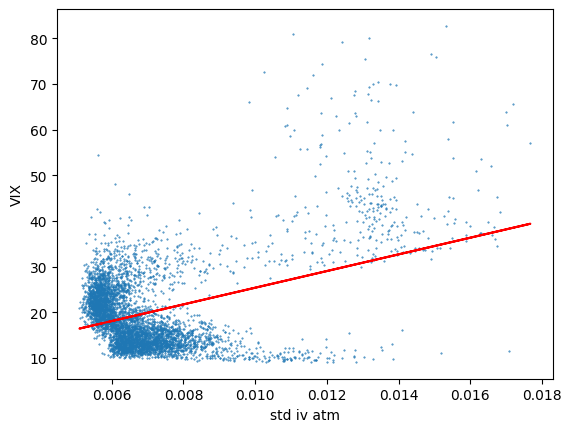

In [8]:
model = smf.ols(f"VIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VIX")
plt.show()

## mean

In [9]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27_simple/model_0_gen3.npy") # no ex feats
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_mean", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_no_ex_mean.tex", "w") as f:
    f.write(latex_format(sm))

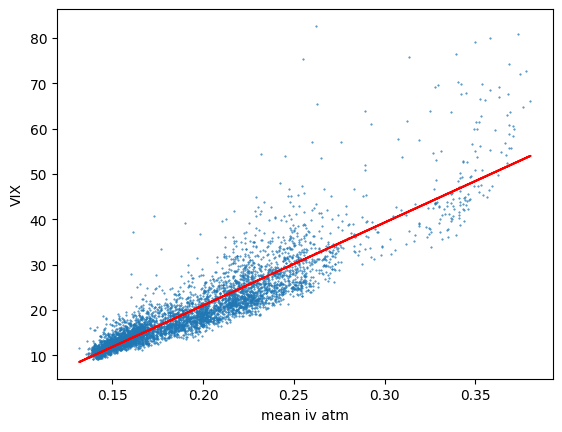

In [10]:
model = smf.ols(f"VIX~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_mean"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_mean"], regression_df1["VIX"], s=0.2)
plt.xlabel("mean iv atm")
plt.ylabel("VIX")
plt.show()

# Regression - no loss on ret

## std

In [11]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27/model_0_gen3.npy") # no loss on ret
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_no_loss_std.tex", "w") as f:
    f.write(latex_format(sm))

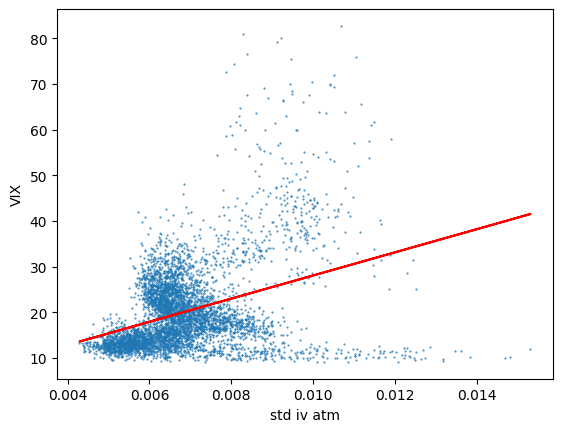

In [12]:
model = smf.ols(f"VIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VIX")
plt.show()

## mean

In [13]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulated_surfaces = np.load("test_spx/2023_08_27/model_0_gen3.npy") # no loss on ret
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_mean", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_no_loss_mean.tex", "w") as f:
    f.write(latex_format(sm))

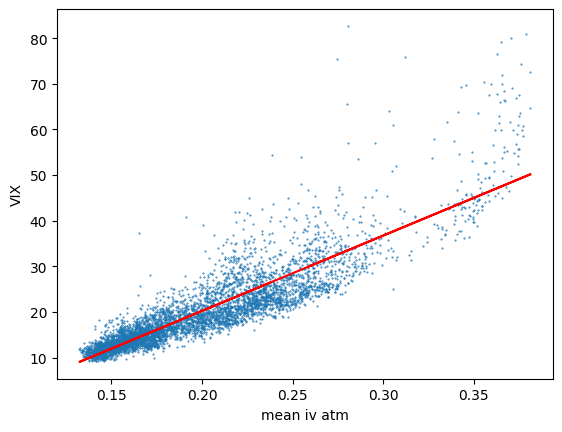

In [14]:
model = smf.ols(f"VIX~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_mean"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_mean"], regression_df1["VIX"], s=0.2)
plt.xlabel("mean iv atm")
plt.ylabel("VIX")
plt.show()

# Regression - loss on ret

## std

In [15]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
# spx_df["VIX"] = -1 / spx_df["VIX"] # change this line to play with different linearization
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/2023_08_27/model_1_gen3.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_std = np.std(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_std"] = simulated_atm_std

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_std", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_loss_std.tex", "w") as f:
    f.write(latex_format(sm))

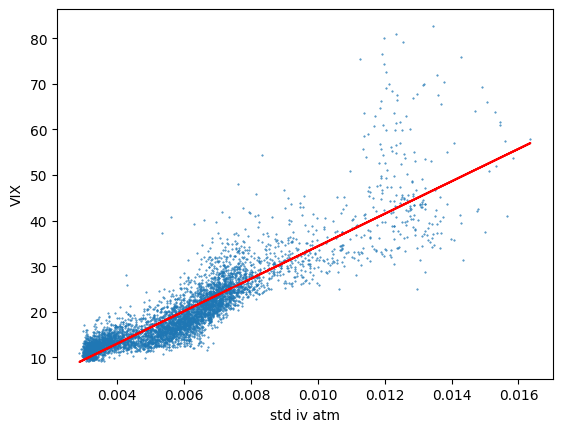

In [16]:
model = smf.ols(f"VIX~1+iv_atm_std", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_std"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_std"], regression_df1["VIX"], s=0.2)
plt.xlabel("std iv atm")
plt.ylabel("VIX")
plt.show()

## mean

In [17]:
spx_df = pd.read_parquet("data/spx_with_vix.parquet")
for i in range(1, 11):
    spx_df[f"VIX_p{i}"] = spx_df["VIX"].shift(-i)
    spx_df[f"abs_delta_VIX_p{i}"] = np.abs(spx_df[f"VIX_p{i}"] - spx_df["VIX"].shift(1))
simulation = np.load("test_spx/2023_08_27/model_1_gen3.npz") # loss on ret
simulated_surfaces = simulation["surfaces"]
simulated_atm = simulated_surfaces[:, :, 3, 2]
simulated_atm_mean = np.mean(simulated_atm, axis=1)

regression_df = spx_df.loc[3:5303-1, 
["date", "VIX", "delta_VIX", "abs_delta_VIX"] + [f"VIX_p{i}" for i in range(1, 11)] + [f"abs_delta_VIX_p{i}" for i in range(1, 11)]]
regression_df1 = regression_df.copy()
regression_df1["iv_atm_mean"] = simulated_atm_mean

models = []
for y in ["VIX", "abs_delta_VIX"]:
    model = smf.ols(f"{y}~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
    models.append(model)

sm = summary_col(models, model_names=["VIX", "abs_delta_VIX"], stars=True,
                 regressor_order=["iv_atm_mean", "Intercept"],
                 info_dict={'$N$':lambda x: "{0:d}".format(int(x.nobs))})
with open("tables/reg_overall_loss_mean.tex", "w") as f:
    f.write(latex_format(sm))

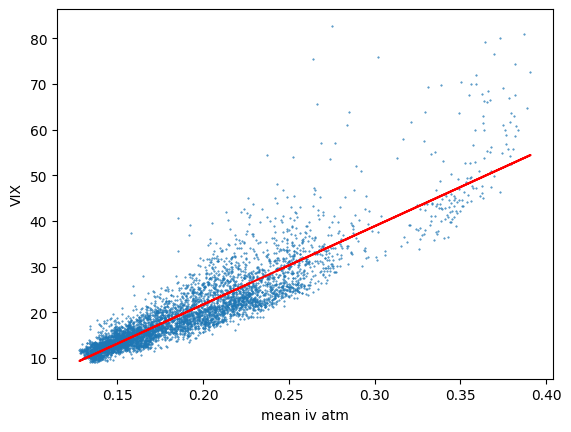

In [18]:
model = smf.ols(f"VIX~1+iv_atm_mean", data=regression_df1).fit(cov_type="HC3")
y_pred = model.predict(regression_df1)
plt.plot(regression_df1["iv_atm_mean"], y_pred, color="red")
plt.scatter(regression_df1["iv_atm_mean"], regression_df1["VIX"], s=0.2)
plt.xlabel("mean iv atm")
plt.ylabel("VIX")
plt.show()

In [19]:
regression_df1["date"]

3      2000-01-06
4      2000-01-07
5      2000-01-10
6      2000-01-11
7      2000-01-12
          ...    
5298   2021-01-27
5299   2021-01-28
5300   2021-01-29
5301   2021-02-01
5302   2021-02-02
Name: date, Length: 5300, dtype: datetime64[ns]